In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
EPOCHS = 50  # Sufficient for good results on T4 GPU
LATENT_DIM = 20
INPUT_DIM = 784  # 28x28
NUM_CLASSES = 10
HIDDEN_DIM = 512  # Increased for better capacity

class ConditionalVAE(nn.Module):
    """
    Conditional Variational Autoencoder for digit-specific generation

    The key insight: By concatenating one-hot encoded digit labels to both
    the input (encoder) and latent code (decoder), we can control what digit
    the model generates.
    """
    def __init__(self, input_dim=784, hidden_dim=512, latent_dim=20, num_classes=10):
        super(ConditionalVAE, self).__init__()

        self.num_classes = num_classes
        self.latent_dim = latent_dim

        # Encoder: input + label -> latent parameters
        # Input: [batch_size, input_dim + num_classes]
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Latent space parameters
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder: latent + label -> output
        # Input: [batch_size, latent_dim + num_classes]
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Output pixel values in [0,1]
        )

    def encode(self, x, labels):
        """Encode input image + label to latent parameters"""
        # Convert labels to one-hot encoding
        labels_onehot = F.one_hot(labels, num_classes=self.num_classes).float()

        # Concatenate image with label
        x_labeled = torch.cat([x, labels_onehot], dim=1)

        # Pass through encoder
        h = self.encoder(x_labeled)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Sample from latent distribution using reparameterization trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, labels):
        """Decode latent code + label to output image"""
        # Convert labels to one-hot encoding
        labels_onehot = F.one_hot(labels, num_classes=self.num_classes).float()

        # Concatenate latent code with label
        z_labeled = torch.cat([z, labels_onehot], dim=1)

        # Pass through decoder
        return self.decoder(z_labeled)

    def forward(self, x, labels):
        """Full forward pass: encode -> sample -> decode"""
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, labels)
        return x_recon, mu, logvar

def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE loss = Reconstruction Loss + KL Divergence Loss

    Args:
        recon_x: Reconstructed images
        x: Original images
        mu: Mean of latent distribution
        logvar: Log variance of latent distribution
        beta: Weight for KL term (beta-VAE)
    """
    # Reconstruction loss (how well we reconstruct the input)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence loss (how close latent distribution is to standard normal)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + beta * KLD

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor and normalize to [0,1]
])

print("Loading MNIST dataset...")
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize model
print("Initializing Conditional VAE...")
model = ConditionalVAE(
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM,
    latent_dim=LATENT_DIM,
    num_classes=NUM_CLASSES
).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training function
def train_epoch(model, train_loader, optimizer, epoch):
    """Train for one epoch"""
    model.train()
    train_loss = 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch:2d}')

    for batch_idx, (data, labels) in enumerate(progress_bar):
        # Move data to device
        data = data.view(-1, INPUT_DIM).to(device)  # Flatten images
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        recon_data, mu, logvar = model(data, labels)

        # Compute loss
        loss = vae_loss_function(recon_data, data, mu, logvar)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Update progress bar
        if batch_idx % 100 == 0:
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.2f}',
                'Avg': f'{train_loss/(batch_idx+1):.2f}'
            })

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch:2d} - Average Loss: {avg_loss:.4f}')
    return avg_loss

# Training loop
print("Starting training...")
print(f"Training for {EPOCHS} epochs on {device}")
print("-" * 50)

losses = []
for epoch in range(1, EPOCHS + 1):
    loss = train_epoch(model, train_loader, optimizer, epoch)
    losses.append(loss)

    # Save checkpoint every 10 epochs
    if epoch % 10 == 0:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'losses': losses,
            'model_config': {
                'input_dim': INPUT_DIM,
                'hidden_dim': HIDDEN_DIM,
                'latent_dim': LATENT_DIM,
                'num_classes': NUM_CLASSES
            }
        }
        torch.save(checkpoint, f'cvae_checkpoint_epoch_{epoch}.pth')
        print(f"Checkpoint saved at epoch {epoch}")

# Save final model
print("\nTraining completed! Saving final model...")
final_checkpoint = {
    'model_state_dict': model.state_dict(),
    'model_config': {
        'input_dim': INPUT_DIM,
        'hidden_dim': HIDDEN_DIM,
        'latent_dim': LATENT_DIM,
        'num_classes': NUM_CLASSES
    },
    'losses': losses
}
torch.save(final_checkpoint, 'cvae_mnist_final.pth')
print("Final model saved as 'cvae_mnist_final.pth'")

Using device: cuda
Loading MNIST dataset...


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.86MB/s]


Initializing Conditional VAE...
Starting training...
Training for 50 epochs on cuda
--------------------------------------------------


Epoch  1: 100%|██████████| 469/469 [00:08<00:00, 55.39it/s, Loss=19096.36, Avg=22460.77]


Epoch  1 - Average Loss: 170.6063


Epoch  2: 100%|██████████| 469/469 [00:07<00:00, 66.00it/s, Loss=16379.05, Avg=17245.46]


Epoch  2 - Average Loss: 133.9597


Epoch  3: 100%|██████████| 469/469 [00:08<00:00, 56.41it/s, Loss=15242.00, Avg=16157.01]


Epoch  3 - Average Loss: 125.7015


Epoch  4: 100%|██████████| 469/469 [00:07<00:00, 60.80it/s, Loss=14860.12, Avg=15545.21]


Epoch  4 - Average Loss: 121.2117


Epoch  5: 100%|██████████| 469/469 [00:07<00:00, 65.11it/s, Loss=14862.19, Avg=15208.40]


Epoch  5 - Average Loss: 118.7839


Epoch  6: 100%|██████████| 469/469 [00:07<00:00, 60.24it/s, Loss=15166.44, Avg=15004.51]


Epoch  6 - Average Loss: 117.1873


Epoch  7: 100%|██████████| 469/469 [00:09<00:00, 51.74it/s, Loss=14915.89, Avg=14863.30]


Epoch  7 - Average Loss: 116.0763


Epoch  8: 100%|██████████| 469/469 [00:07<00:00, 66.27it/s, Loss=14625.07, Avg=14752.06]


Epoch  8 - Average Loss: 115.1918


Epoch  9: 100%|██████████| 469/469 [00:07<00:00, 60.81it/s, Loss=14913.27, Avg=14665.24]


Epoch  9 - Average Loss: 114.5122


Epoch 10: 100%|██████████| 469/469 [00:07<00:00, 62.95it/s, Loss=14953.94, Avg=14577.60]


Epoch 10 - Average Loss: 113.9569
Checkpoint saved at epoch 10


Epoch 11: 100%|██████████| 469/469 [00:07<00:00, 62.47it/s, Loss=13849.90, Avg=14517.04]


Epoch 11 - Average Loss: 113.4181


Epoch 12: 100%|██████████| 469/469 [00:07<00:00, 61.07it/s, Loss=14157.24, Avg=14474.78]


Epoch 12 - Average Loss: 113.1115


Epoch 13: 100%|██████████| 469/469 [00:07<00:00, 65.98it/s, Loss=14215.76, Avg=14431.53]


Epoch 13 - Average Loss: 112.6936


Epoch 14: 100%|██████████| 469/469 [00:07<00:00, 60.23it/s, Loss=14157.49, Avg=14389.68]


Epoch 14 - Average Loss: 112.4704


Epoch 15: 100%|██████████| 469/469 [00:07<00:00, 60.65it/s, Loss=14028.03, Avg=14352.15]


Epoch 15 - Average Loss: 112.1077


Epoch 16: 100%|██████████| 469/469 [00:07<00:00, 62.46it/s, Loss=13909.51, Avg=14305.38]


Epoch 16 - Average Loss: 111.8687


Epoch 17: 100%|██████████| 469/469 [00:07<00:00, 60.11it/s, Loss=14446.10, Avg=14293.60]


Epoch 17 - Average Loss: 111.6383


Epoch 18: 100%|██████████| 469/469 [00:07<00:00, 60.51it/s, Loss=13934.79, Avg=14263.19]


Epoch 18 - Average Loss: 111.4193


Epoch 19: 100%|██████████| 469/469 [00:07<00:00, 65.40it/s, Loss=14014.51, Avg=14239.38]


Epoch 19 - Average Loss: 111.2311


Epoch 20: 100%|██████████| 469/469 [00:07<00:00, 60.72it/s, Loss=14491.99, Avg=14217.50]


Epoch 20 - Average Loss: 111.0615
Checkpoint saved at epoch 20


Epoch 21: 100%|██████████| 469/469 [00:07<00:00, 65.56it/s, Loss=13695.75, Avg=14178.62]


Epoch 21 - Average Loss: 110.8505


Epoch 22: 100%|██████████| 469/469 [00:07<00:00, 60.97it/s, Loss=13873.71, Avg=14161.34]


Epoch 22 - Average Loss: 110.7395


Epoch 23: 100%|██████████| 469/469 [00:07<00:00, 60.76it/s, Loss=14721.60, Avg=14163.10]


Epoch 23 - Average Loss: 110.6508


Epoch 24: 100%|██████████| 469/469 [00:07<00:00, 66.28it/s, Loss=14129.43, Avg=14154.07]


Epoch 24 - Average Loss: 110.5385


Epoch 25: 100%|██████████| 469/469 [00:07<00:00, 61.19it/s, Loss=14303.79, Avg=14122.81]


Epoch 25 - Average Loss: 110.3579


Epoch 26: 100%|██████████| 469/469 [00:07<00:00, 62.66it/s, Loss=13333.90, Avg=14106.47]


Epoch 26 - Average Loss: 110.2413


Epoch 27: 100%|██████████| 469/469 [00:07<00:00, 64.48it/s, Loss=13853.84, Avg=14093.79]


Epoch 27 - Average Loss: 110.1710


Epoch 28: 100%|██████████| 469/469 [00:07<00:00, 60.45it/s, Loss=14384.09, Avg=14075.38]


Epoch 28 - Average Loss: 110.0149


Epoch 29: 100%|██████████| 469/469 [00:07<00:00, 66.33it/s, Loss=14075.94, Avg=14077.45]


Epoch 29 - Average Loss: 109.9637


Epoch 30: 100%|██████████| 469/469 [00:07<00:00, 61.20it/s, Loss=13746.99, Avg=14054.15]


Epoch 30 - Average Loss: 109.8498
Checkpoint saved at epoch 30


Epoch 31: 100%|██████████| 469/469 [00:07<00:00, 60.93it/s, Loss=14235.47, Avg=14061.96]


Epoch 31 - Average Loss: 109.7868


Epoch 32: 100%|██████████| 469/469 [00:07<00:00, 66.27it/s, Loss=13945.38, Avg=14027.30]


Epoch 32 - Average Loss: 109.6566


Epoch 33: 100%|██████████| 469/469 [00:07<00:00, 60.87it/s, Loss=14778.22, Avg=14038.48]


Epoch 33 - Average Loss: 109.6965


Epoch 34: 100%|██████████| 469/469 [00:07<00:00, 63.86it/s, Loss=14143.81, Avg=14038.77]


Epoch 34 - Average Loss: 109.5813


Epoch 35: 100%|██████████| 469/469 [00:07<00:00, 63.35it/s, Loss=14667.62, Avg=13995.57]


Epoch 35 - Average Loss: 109.4217


Epoch 36: 100%|██████████| 469/469 [00:07<00:00, 60.91it/s, Loss=14092.94, Avg=14003.85]


Epoch 36 - Average Loss: 109.3985


Epoch 37: 100%|██████████| 469/469 [00:07<00:00, 65.97it/s, Loss=13655.79, Avg=13992.70]


Epoch 37 - Average Loss: 109.3966


Epoch 38: 100%|██████████| 469/469 [00:07<00:00, 61.19it/s, Loss=14216.18, Avg=13984.94]


Epoch 38 - Average Loss: 109.2529


Epoch 39: 100%|██████████| 469/469 [00:07<00:00, 61.11it/s, Loss=14421.25, Avg=13975.68]


Epoch 39 - Average Loss: 109.2558


Epoch 40: 100%|██████████| 469/469 [00:07<00:00, 66.00it/s, Loss=14593.51, Avg=13967.07]


Epoch 40 - Average Loss: 109.1504
Checkpoint saved at epoch 40


Epoch 41: 100%|██████████| 469/469 [00:07<00:00, 60.55it/s, Loss=14331.60, Avg=13965.30]


Epoch 41 - Average Loss: 109.1040


Epoch 42: 100%|██████████| 469/469 [00:07<00:00, 63.81it/s, Loss=13706.85, Avg=13941.77]


Epoch 42 - Average Loss: 108.9957


Epoch 43: 100%|██████████| 469/469 [00:07<00:00, 62.44it/s, Loss=14176.80, Avg=13966.65]


Epoch 43 - Average Loss: 109.0399


Epoch 44: 100%|██████████| 469/469 [00:07<00:00, 61.11it/s, Loss=14062.08, Avg=13924.86]


Epoch 44 - Average Loss: 108.8658


Epoch 45: 100%|██████████| 469/469 [00:07<00:00, 65.90it/s, Loss=14444.50, Avg=13935.23]


Epoch 45 - Average Loss: 108.8842


Epoch 46: 100%|██████████| 469/469 [00:07<00:00, 60.64it/s, Loss=13968.31, Avg=13921.71]


Epoch 46 - Average Loss: 108.9062


Epoch 47: 100%|██████████| 469/469 [00:07<00:00, 61.06it/s, Loss=13878.62, Avg=13927.52]


Epoch 47 - Average Loss: 108.8392


Epoch 48: 100%|██████████| 469/469 [00:07<00:00, 66.22it/s, Loss=13498.37, Avg=13910.43]


Epoch 48 - Average Loss: 108.7132


Epoch 49: 100%|██████████| 469/469 [00:07<00:00, 60.82it/s, Loss=14372.42, Avg=13912.52]


Epoch 49 - Average Loss: 108.6789


Epoch 50: 100%|██████████| 469/469 [00:07<00:00, 64.88it/s, Loss=13758.01, Avg=13926.86]

Epoch 50 - Average Loss: 108.7272
Checkpoint saved at epoch 50

Training completed! Saving final model...
Final model saved as 'cvae_mnist_final.pth'



Testing digit generation...
Generating samples for digit 0...
Generating samples for digit 1...
Generating samples for digit 2...
Generating samples for digit 3...
Generating samples for digit 4...
Generating samples for digit 5...
Generating samples for digit 6...
Generating samples for digit 7...
Generating samples for digit 8...
Generating samples for digit 9...


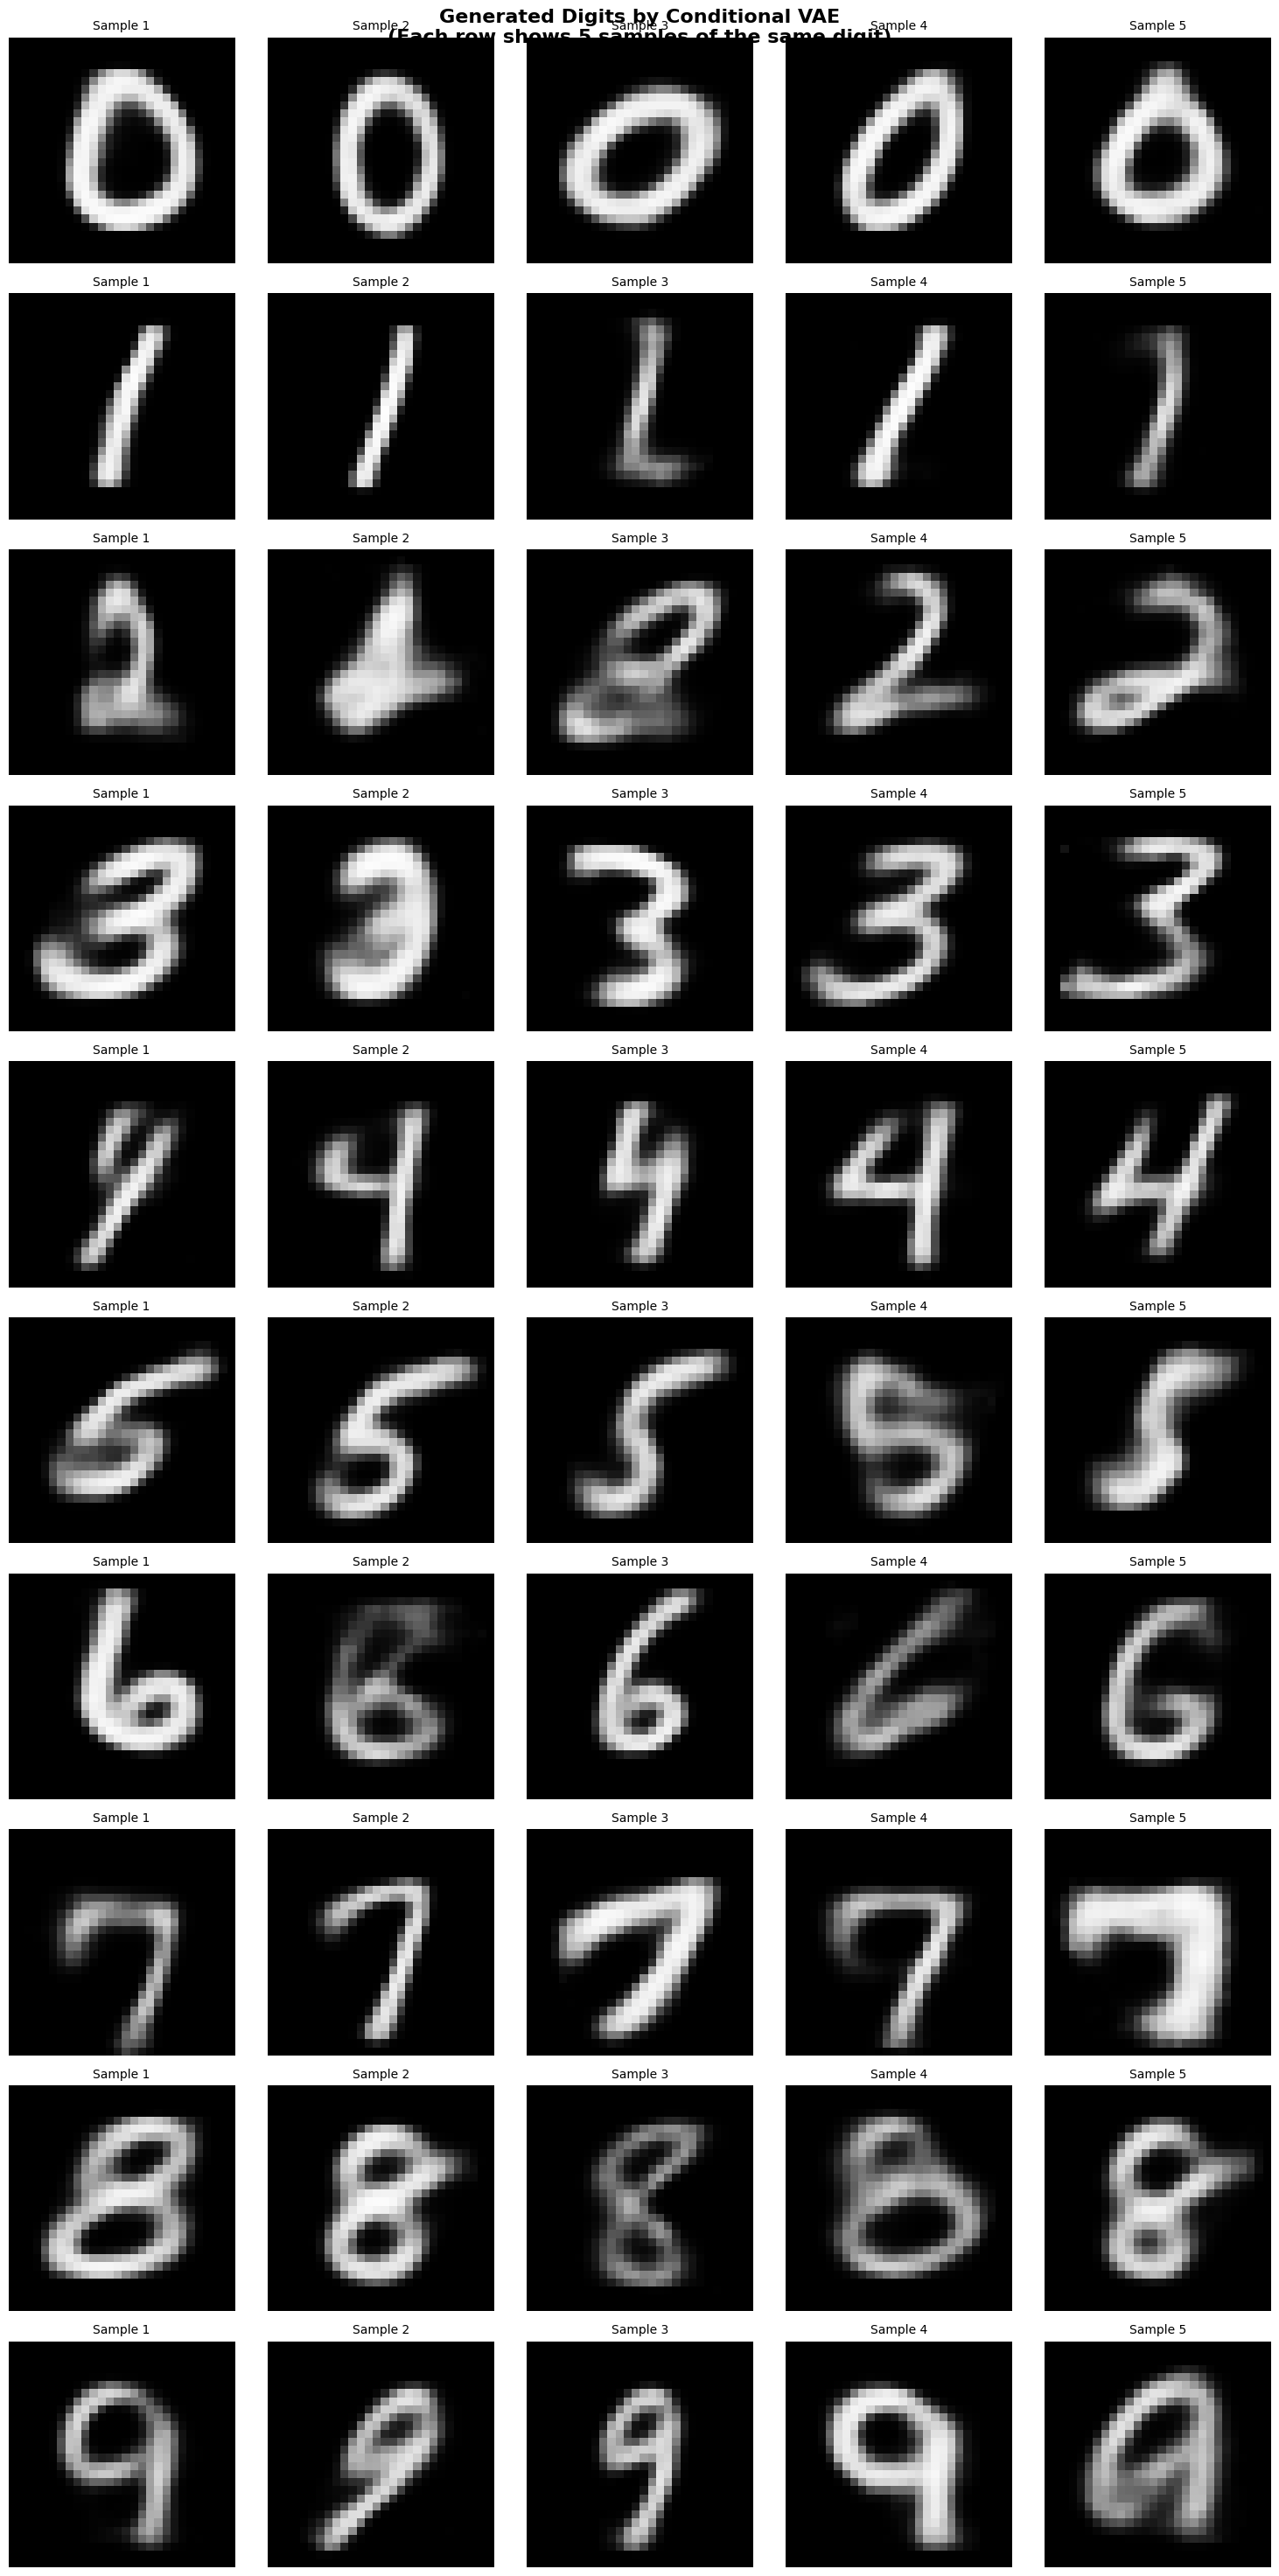

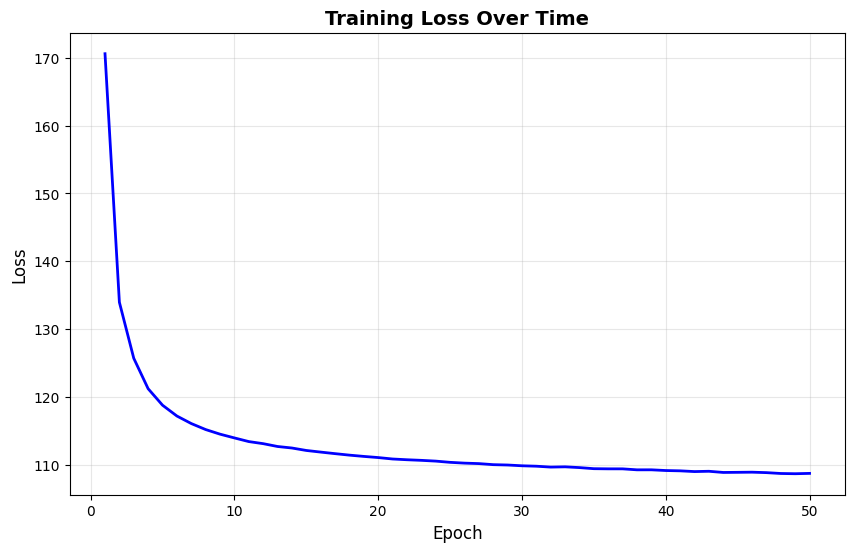


TRAINING SUMMARY
✓ Model trained for 50 epochs
✓ Final loss: 108.7272
✓ Model saved as: cvae_mnist_final.pth
✓ Device used: cuda
✓ Can generate specific digits 0-9
✓ Ready for web app deployment!
✓ Model utilities saved for web app integration


In [2]:
def generate_specific_digit(model, digit_class, num_samples=5, device='cpu'):
    """
    Generate specific digits using the trained Conditional VAE

    Args:
        model: Trained ConditionalVAE model
        digit_class: Which digit to generate (0-9)
        num_samples: How many samples to generate
        device: Device to run on

    Returns:
        Generated images as numpy array [num_samples, 28, 28]
    """
    model.eval()
    with torch.no_grad():
        # Create labels for the desired digit (this is how we control generation!)
        labels = torch.full((num_samples,), digit_class, dtype=torch.long).to(device)

        # Sample random latent codes
        z = torch.randn(num_samples, model.latent_dim).to(device)

        # Generate images conditioned on the specific digit label
        generated = model.decode(z, labels)

        # Reshape to image format and move to CPU
        generated = generated.view(-1, 28, 28).cpu().numpy()

        # Ensure values are in [0, 1] range
        generated = np.clip(generated, 0, 1)

        return generated

# Test the digit generation for all digits
print("\nTesting digit generation...")
model.eval()

# Generate samples for each digit (0-9)
fig, axes = plt.subplots(10, 5, figsize=(15, 30))
fig.suptitle('Generated Digits by Conditional VAE\n(Each row shows 5 samples of the same digit)',
             fontsize=16, fontweight='bold')

for digit in range(10):
    print(f"Generating samples for digit {digit}...")
    generated_samples = generate_specific_digit(model, digit, num_samples=5, device=device)

    for sample_idx in range(5):
        row, col = digit, sample_idx
        axes[row, col].imshow(generated_samples[sample_idx], cmap='gray', vmin=0, vmax=1)
        axes[row, col].axis('off')

        if sample_idx == 0:  # Label only the first column
            axes[row, col].set_ylabel(f'Digit {digit}', fontsize=14, fontweight='bold')

        axes[row, col].set_title(f'Sample {sample_idx + 1}', fontsize=10)

plt.tight_layout()
plt.savefig('generated_digits_test.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot training loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses) + 1), losses, 'b-', linewidth=2)
plt.title('Training Loss Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig('training_loss_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*50)
print("TRAINING SUMMARY")
print("="*50)
print(f"✓ Model trained for {EPOCHS} epochs")
print(f"✓ Final loss: {losses[-1]:.4f}")
print(f"✓ Model saved as: cvae_mnist_final.pth")
print(f"✓ Device used: {device}")
print(f"✓ Can generate specific digits 0-9")
print("✓ Ready for web app deployment!")
print("="*50)

# Save generation function for web app
generation_code = f'''
# Generation function for web app
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class ConditionalVAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=512, latent_dim=20, num_classes=10):
        super(ConditionalVAE, self).__init__()

        self.num_classes = num_classes
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def decode(self, z, labels):
        labels_onehot = F.one_hot(labels, num_classes=self.num_classes).float()
        z_labeled = torch.cat([z, labels_onehot], dim=1)
        return self.decoder(z_labeled)

def load_model_and_generate(digit_class, num_samples=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load model
    model = ConditionalVAE(hidden_dim=512, latent_dim=20).to(device)
    checkpoint = torch.load('cvae_mnist_final.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Generate specific digit
    with torch.no_grad():
        labels = torch.full((num_samples,), digit_class, dtype=torch.long).to(device)
        z = torch.randn(num_samples, 20).to(device)
        generated = model.decode(z, labels)
        generated = generated.view(-1, 28, 28).cpu().numpy()
        return np.clip(generated, 0, 1)
'''

with open('model_utils.py', 'w') as f:
    f.write(generation_code)

print("✓ Model utilities saved for web app integration")